In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz, debug

# Train on 440 hz Sines with random phases

A very simple dataset, should be able to crush this. Sines all at 440 hz, unit amplitude, random phases. Some ways of reducing the size of the problems:

- 4 cycles of sin should do, no need for a full second of audio. 160 samples
- Mu compress to 7 bits
- Fast generate only 160 samples
- Mono

We will try to train in around 10 minutes. 

In [3]:
dry = True 
if dry: os.environ['WANDB_MODE'] = 'disabled'

In [4]:
p = model.HParams(
    mixed_precision=True,
    n_audio_chans=1, 
    n_classes=2**7, 
    compress=False, 
    sample_length=160, 
    dilation_stacks=1,
    n_layers=8,
    sample_from_gpu=True,
    seed=32455
    
).with_all_chans(32)

utils.seed(p)
ds = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0
)

ds_test = datasets.Sines(
    640, p, 
    hz=440, 
    amp=1.0
)

m = model.Wavenet(p)
debug.summarize(m)

tp = train.HParams(
    max_epochs=10, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.015, 
    onecycle=True
)

t = train.Trainer(m, ds, ds_test, tp, None)

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|       input.weight      |     64     |
|        input.bias       |     32     |
|   layers.0.conv.weight  |    4096    |
|    layers.0.conv.bias   |     64     |
|  layers.0.res1x1.weight |    1024    |
|   layers.0.res1x1.bias  |     32     |
| layers.0.skip1x1.weight |    1024    |
|  layers.0.skip1x1.bias  |     32     |
|   layers.1.conv.weight  |    4096    |
|    layers.1.conv.bias   |     64     |
|  layers.1.res1x1.weight |    1024    |
|   layers.1.res1x1.bias  |     32     |
| layers.1.skip1x1.weight |    1024    |
|  layers.1.skip1x1.bias  |     32     |
|   layers.2.conv.weight  |    4096    |
|    layers.2.conv.bias   |     64     |
|  layers.2.res1x1.weight |    1024    |
|   layers.2.res1x1.bias  |     32     |
| layers.2.skip1x1.weight |    1024    |
|  layers.2.skip1x1.bias  |     32     |
|   layers.3.conv.weight  |    4096    |
|    layers.3.co

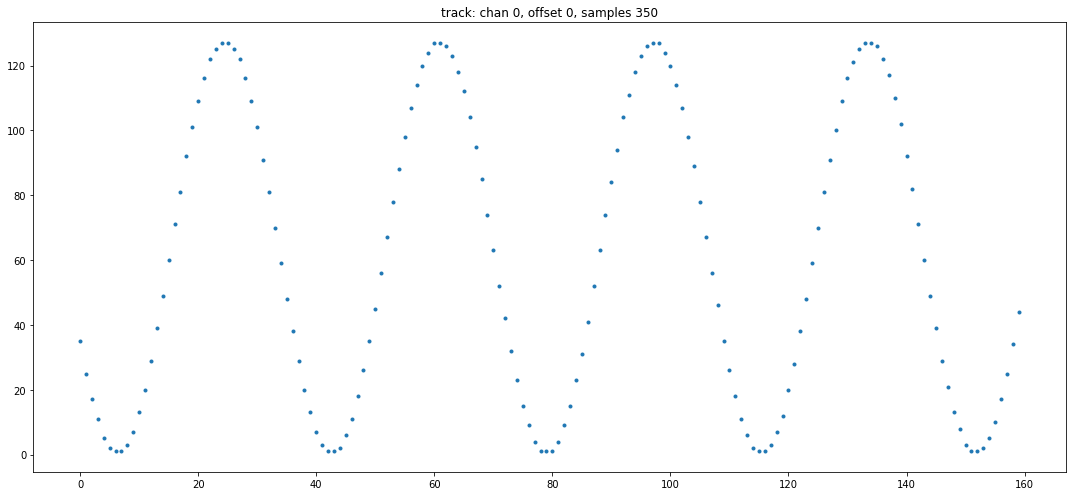

In [5]:
track_i = viz.plot_random_track(ds, style='.')
*_, track = ds[track_i]
ipd.Audio(track, rate=p.sampling_rate)

In [6]:
utils.seed(p)
t.train()

  0%|          | 0/40 [00:00<?, ?it/s]/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
10:39 loss 0.47324 lr 5.320725e-07: 100%|██████████| 40/40 [00:01<00:00, 29.34it/s]


# Results

Let's inspect what the model has learned by generating samples and laying them over each other.

In [7]:
def generate(m, ds, decoder, n_samples=256, batch_size = 10):
    track, *_ = sample.fast(m, ds.transforms, decoder, n_samples=n_samples, batch_size=batch_size)
    plt.figure(figsize=(15, 8))
    for i in range(batch_size):
        plt.plot(track.cpu()[i, 0, :])

## Argmax

The model has learned that sin is the most likely mode of the data. This is with starting values of 0. I'm not sure why this should be the case exactly, since I would expect starting values to be uniformly distributed between 0 and 120.

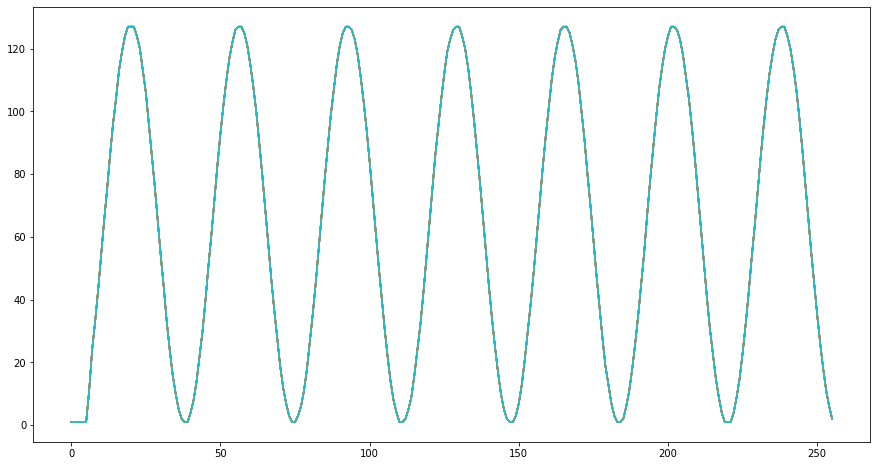

In [8]:
utils.seed(p)
generate(m, ds, utils.decode_argmax)

## Nucleus sampling with very likely values

Using nucleus sampling, we can relax the argmax a bit. Here we retain the top propbability mass. Now we've captured both `sin` and `cos`, respectively starting at the minimum and maximum values.

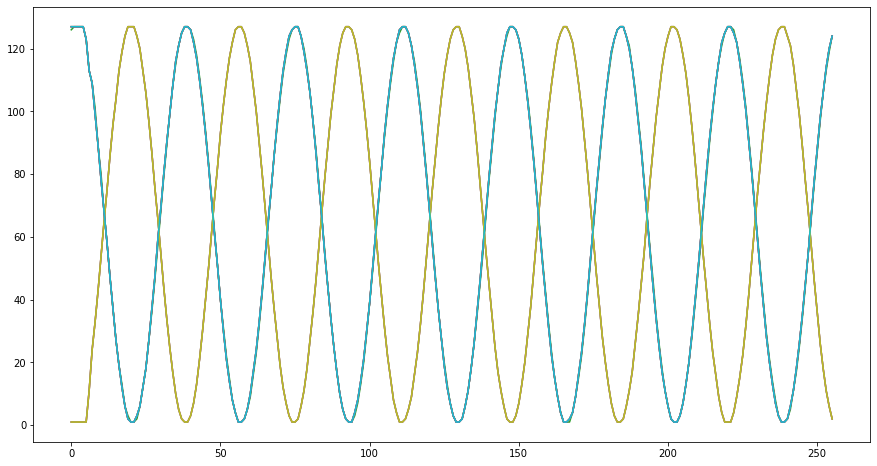

In [9]:
utils.seed(p)
generate(m, ds, utils.decode_nucleus(core_mass=0.14))

## Nucleus sampling, relaxed a bit more

Now we've grabbed a further mode, which sometimes starts in the middle at 60 – the mean of `sin` and `cos`. There's more jitter overall.

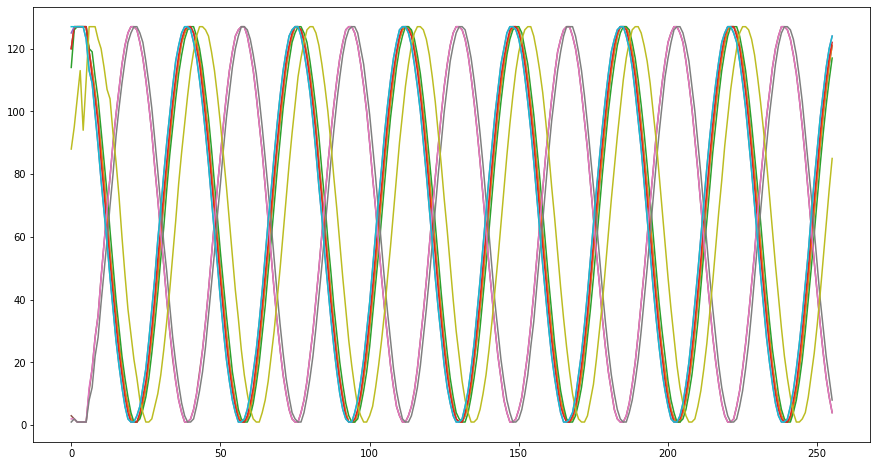

In [10]:
utils.seed(p)
generate(m, ds, utils.decode_nucleus(core_mass=0.4))

## Random

Now we're trying to reproduce the original distribution. Note that we still haven't got a very uniform reproduction.

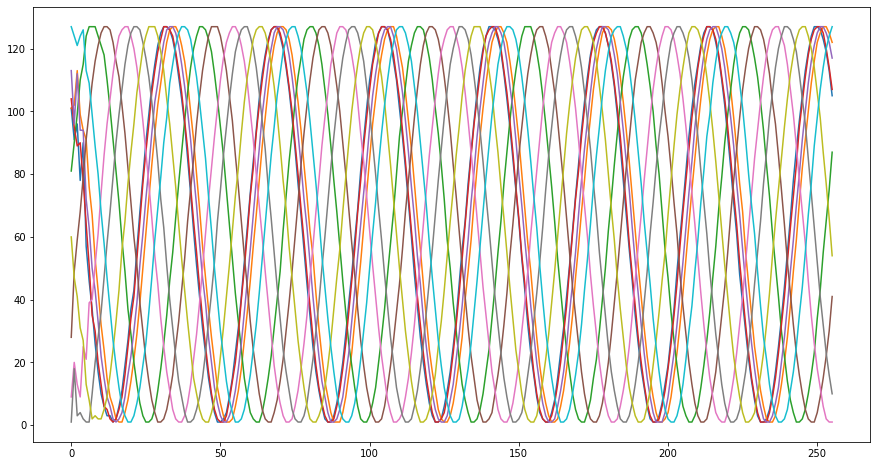

In [11]:
utils.seed(p)
generate(m, ds, utils.decode_random)

# Train on random Sinusoids

Harder.

In [12]:
utils.seed(p)
ds = datasets.Sines(6400, p, amp=1.0, minhz=20, maxhz=400)
ds_test =datasets.Sines(640, p, amp=1.0, minhz=20, maxhz=400)

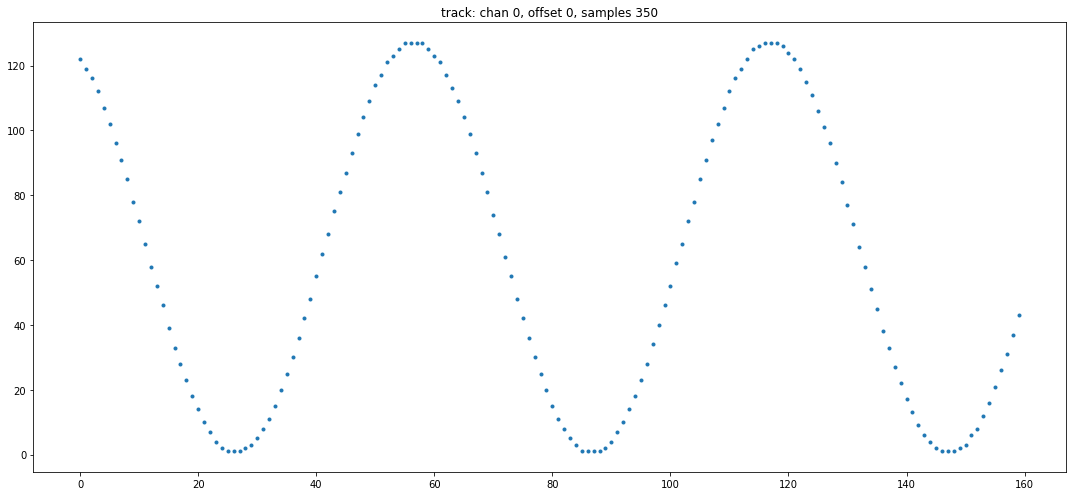

In [13]:
track_i = viz.plot_random_track(ds, style='.')
*_, track = ds[track_i]
ipd.Audio(track, rate=p.sampling_rate)

In [14]:
m = model.Wavenet(p.with_all_chans(64))
debug.summarize(m)

tp = train.HParams(
    max_epochs=40, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.008,
    onecycle=True
)

t = train.Trainer(m, ds, ds_test, tp, None)
p.receptive_field_size()

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|       input.weight      |    128     |
|        input.bias       |     64     |
|   layers.0.conv.weight  |   16384    |
|    layers.0.conv.bias   |    128     |
|  layers.0.res1x1.weight |    4096    |
|   layers.0.res1x1.bias  |     64     |
| layers.0.skip1x1.weight |    4096    |
|  layers.0.skip1x1.bias  |     64     |
|   layers.1.conv.weight  |   16384    |
|    layers.1.conv.bias   |    128     |
|  layers.1.res1x1.weight |    4096    |
|   layers.1.res1x1.bias  |     64     |
| layers.1.skip1x1.weight |    4096    |
|  layers.1.skip1x1.bias  |     64     |
|   layers.2.conv.weight  |   16384    |
|    layers.2.conv.bias   |    128     |
|  layers.2.res1x1.weight |    4096    |
|   layers.2.res1x1.bias  |     64     |
| layers.2.skip1x1.weight |    4096    |
|  layers.2.skip1x1.bias  |     64     |
|   layers.3.conv.weight  |   16384    |
|    layers.3.co

256

In [15]:
utils.seed(p)
t.train()

  0%|          | 0/400 [00:00<?, ?it/s]/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
40:399 loss 0.30987 lr 3.215736e-08: 100%|██████████| 400/400 [00:12<00:00, 31.06it/s]


## Argmax

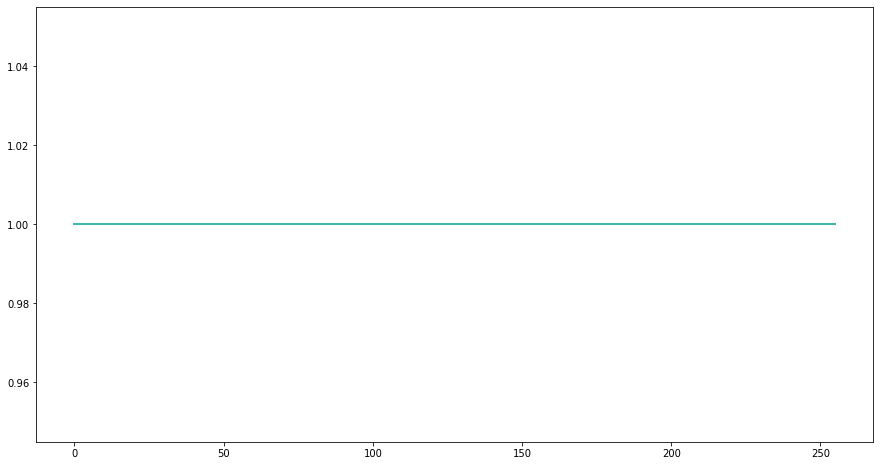

In [16]:
utils.seed(p)
generate(m, ds, utils.decode_argmax)

## Nucleus sampling with very likely values


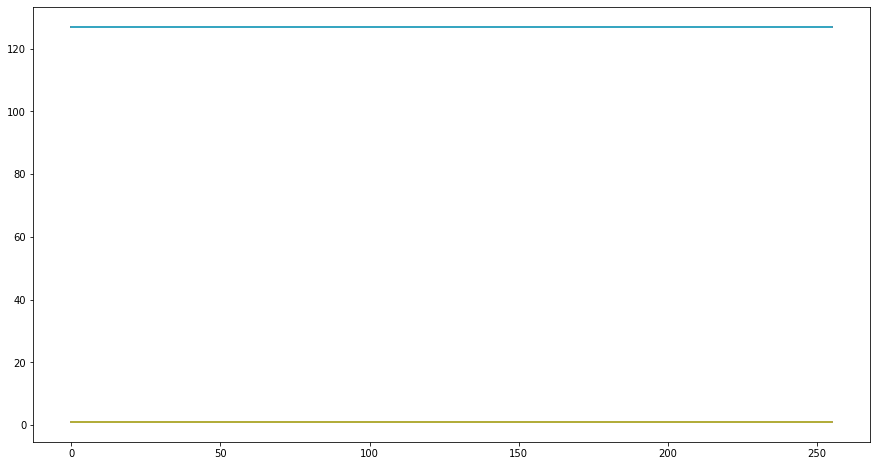

In [17]:
utils.seed(p)
generate(m, ds, utils.decode_nucleus(core_mass=0.14))

## Nucleus sampling, relaxed a bit more


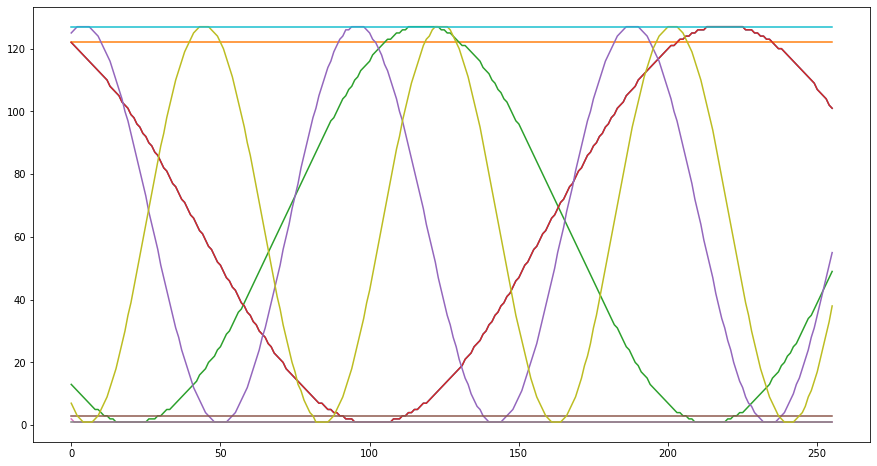

In [18]:
utils.seed(p)
generate(m, ds, utils.decode_nucleus(core_mass=0.4))

## Random

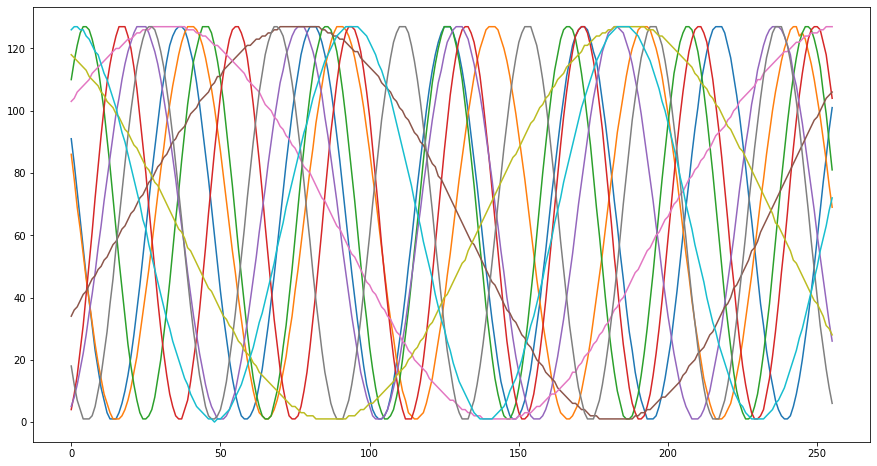

In [22]:
utils.seed(p)
generate(m, ds, utils.decode_random)

## 🚨 Observations and Questions

- This seems to need much longer to converge. Using 4x epochs
- Also using 4x parameters
- Having trouble with the low frequency examples
- Why do we need to up the model and training so much? It is a harder problem, but surely not that much harder?

# Train on 20 hz Sines

Here's a bit of a puzzle. Given the same resources as training on 440 hz sines with random phases, training on 20 hz sines performs much worse:

In [23]:
p = model.HParams(
    mixed_precision=True,
    n_audio_chans=1, 
    n_classes=2**7, 
    compress=False, 
    sample_length=160, 
    dilation_stacks=1,
    n_layers=8,
    sample_from_gpu=True,
    seed=32455
    
).with_all_chans(32)

utils.seed(p)
ds = datasets.Sines(
    640, p, 
    hz=20, 
    amp=1.0
)

ds_test = datasets.Sines(
    640, p, 
    hz=20, 
    amp=1.0
)

m = model.Wavenet(p)
debug.summarize(m)

tp = train.HParams(
    max_epochs=10, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.015, 
    onecycle=True
)

t = train.Trainer(m, ds, ds_test, tp, None)
p.receptive_field_size()

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|       input.weight      |     64     |
|        input.bias       |     32     |
|   layers.0.conv.weight  |    4096    |
|    layers.0.conv.bias   |     64     |
|  layers.0.res1x1.weight |    1024    |
|   layers.0.res1x1.bias  |     32     |
| layers.0.skip1x1.weight |    1024    |
|  layers.0.skip1x1.bias  |     32     |
|   layers.1.conv.weight  |    4096    |
|    layers.1.conv.bias   |     64     |
|  layers.1.res1x1.weight |    1024    |
|   layers.1.res1x1.bias  |     32     |
| layers.1.skip1x1.weight |    1024    |
|  layers.1.skip1x1.bias  |     32     |
|   layers.2.conv.weight  |    4096    |
|    layers.2.conv.bias   |     64     |
|  layers.2.res1x1.weight |    1024    |
|   layers.2.res1x1.bias  |     32     |
| layers.2.skip1x1.weight |    1024    |
|  layers.2.skip1x1.bias  |     32     |
|   layers.3.conv.weight  |    4096    |
|    layers.3.co

256

In [24]:
utils.seed(p)
t.train()

  0%|          | 0/40 [00:00<?, ?it/s]/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
10:39 loss 0.88530 lr 5.320725e-07: 100%|██████████| 40/40 [00:01<00:00, 28.59it/s]


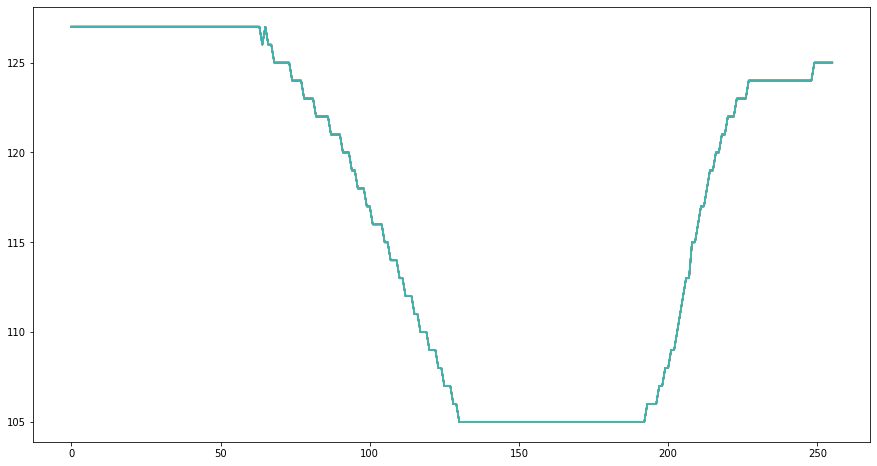

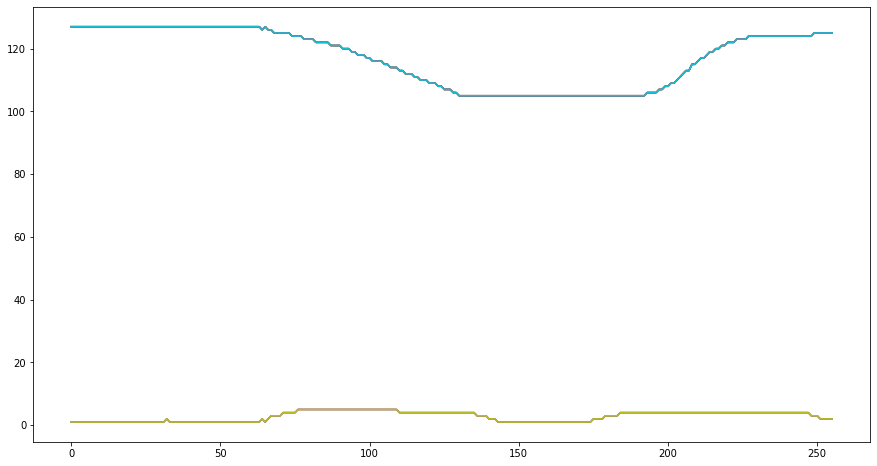

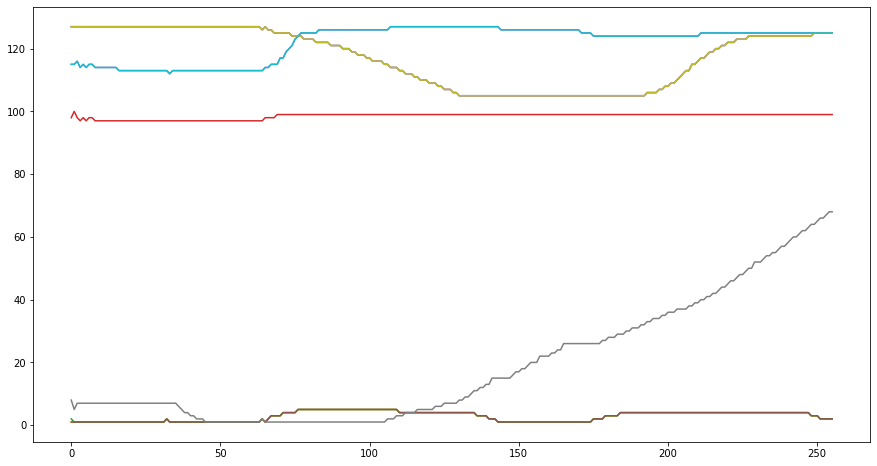

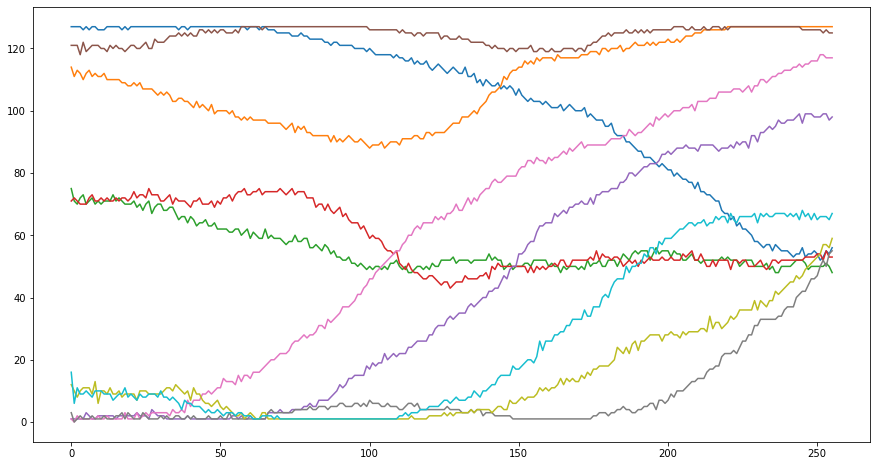

In [25]:
utils.seed(p)
generate(m, ds, utils.decode_argmax)
generate(m, ds, utils.decode_nucleus(core_mass=0.14))
generate(m, ds, utils.decode_nucleus(core_mass=0.4))
generate(m, ds, utils.decode_random)

## 🚨 Observations and Questions

- Why is this doing so much worse, given the only difference is 20 hz vz 440 hz?